## 🎯 Objectif de ce notebook
Cette étape consiste à analyser les avis clients déjà intégrés dans le **Data Lake** sous forme de fichiers Parquet générés par l'étape **LOAD** du pipeline ETL.  
L'analyse vise à :

- **classer automatiquement les avis** selon plusieurs thématiques définies grâce à un modèle **Zero-Shot Classification** ;
- **calculer un score de pertinence** pour chaque avis, en réutilisant les enrichissements produits dans l'étape **TRANSFORM** (has_image, verified_buyer, has_subscription, etc.) ;
- **identifier les avis les plus informatifs** pour chaque produit ;
- produire des **indicateurs actionnables** destinés aux différentes équipes (produit, logistique, client, etc)

## 🏗️ Lien avec les étapes précédentes
Cette analyse repose entièrement sur :

- les données extraites via `extract_all()` à partir des fichiers sources bruts ;
- les transformations appliquées dans `transform_all()` :  
  normalisation du texte, reconstruction des clés, enrichissements (`has_image`, `verified_buyer`, `has_subscription`) ;
- les données consolidées dans le **Data Lake** par `load_all()`, disponibles dans  
  `datalake/cleaned/reviews_cleaned_*.parquet` ;
- le prototype déjà développé, qui introduit le calcul du **relevance_score**.

## 🔍 Contenu de l'analyse
Le présent notebook réalisera les étapes suivantes :

1. Chargement du dernier fichier Parquet issu du Data Warehouse  
2. Analyse exploratoire des avis
3. Application du modèle Zero-Shot
4. Construction du **relevance_score** (repris du prototype)
5. Visualisation et extraction des avis les plus pertinents
6. Conclusion et pistes d'amélioration

---


In [ ]:
# Si besoin, on peut installer les différentes dépendances nécessaires à la visualisation et à la récupération du modèle
pip install matplotlib seaborn transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 📥 Chargement des données nettoyées depuis le Data Lake

Dans cette première étape, nous chargeons les données issues de la **couche cleaned du Data Lake**, générée par le pipeline ETL

Les avis clients ont été :
- extraits depuis la base transactionnelle PostgreSQL,
- nettoyés et enrichis (normalisation du texte, indicateurs métier),
- stockés au format **Parquet** afin d’optimiser le stockage et les performances de lecture.

Nous sélectionnons automatiquement le **fichier Parquet le plus récent**, ce qui permet :
- de garantir que l’analyse repose sur la dernière version des données,
- de rendre le notebook reproductible sans modification manuelle des chemins.

Les données chargées constituent la base de l’ensemble des analyses exploratoires et métier présentées dans la suite du notebook.


In [1]:
import pandas as pd
from pathlib import Path

# Dossier du Data Lake S3
cleaned_dir = Path("datalake") / "cleaned"

# Récupération de tous les fichiers Parquet
parquet_files = sorted(cleaned_dir.glob("reviews_cleaned_*.parquet"))

if not parquet_files:
    raise RuntimeError("❌ Aucun fichier Parquet trouvé dans datalake/cleaned")

# On prend le fichier le plus récent
latest_parquet = parquet_files[-1]
print("📄 Fichier Parquet chargé :", latest_parquet.name)

df_reviews = pd.read_parquet(latest_parquet)

print(f"✔️ {len(df_reviews)} lignes chargées depuis le Data Lake.")
df_reviews.head()


📄 Fichier Parquet chargé : reviews_cleaned_20251214_210001.parquet
✔️ 111036 lignes chargées depuis le Data Lake.


,review_id,buyer_id,product_id,title,review_text,rating,has_image,has_subscription,verified_buyer
0,96001,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,Yes!,"smells good, feels great!",5,False,False,True
1,96002,AE5DIA2HDWBPNGBO2FXN2PF4NQJA,B081GCFHPG,Really nice quality,these are not what i was expecting. they are s...,5,False,True,True
2,96003,AEEM2QIBMUUXEAJIEQH2WT2KNZZA,B07T2L6JQR,Great product,great product,5,False,False,True
3,96004,AEITH2MBDGMCSAZSBNAYOEBOJXFA,B0008F6QGO,great clipper cleaner,only 2 problems with this product expensive an...,5,False,False,True
4,96005,AEHVSZ72XXI4SU6XUNXMJAXUYN6Q,B00JM1BZUW,Four Stars,i'm very happy with my order. will order item ...,4,False,False,True


# 🔍 Analyse exploratoire des avis

Cette section présente une **analyse exploratoire rapide** du dataset issu du Data Warehouse.  
L'objectif est de vérifier :

- la qualité générale des données chargées ;
- la distribution des notes (`rating`) ;
- la longueur des avis (`review_text`) ;
- la présence d'enrichissements utiles (`has_image`, `has_subscription`, `verified_buyer`).

Cette étape permet de valider que les données produites par l'ETL sont **cohérentes, complètes et exploitables** avant d'appliquer le `modèle Zero-Shot` et de construire le `relevance_score`.


Nombre de lignes : 111036
% d'avis avec image : 10.05%
% d'acheteurs vérifiés : 100.00%


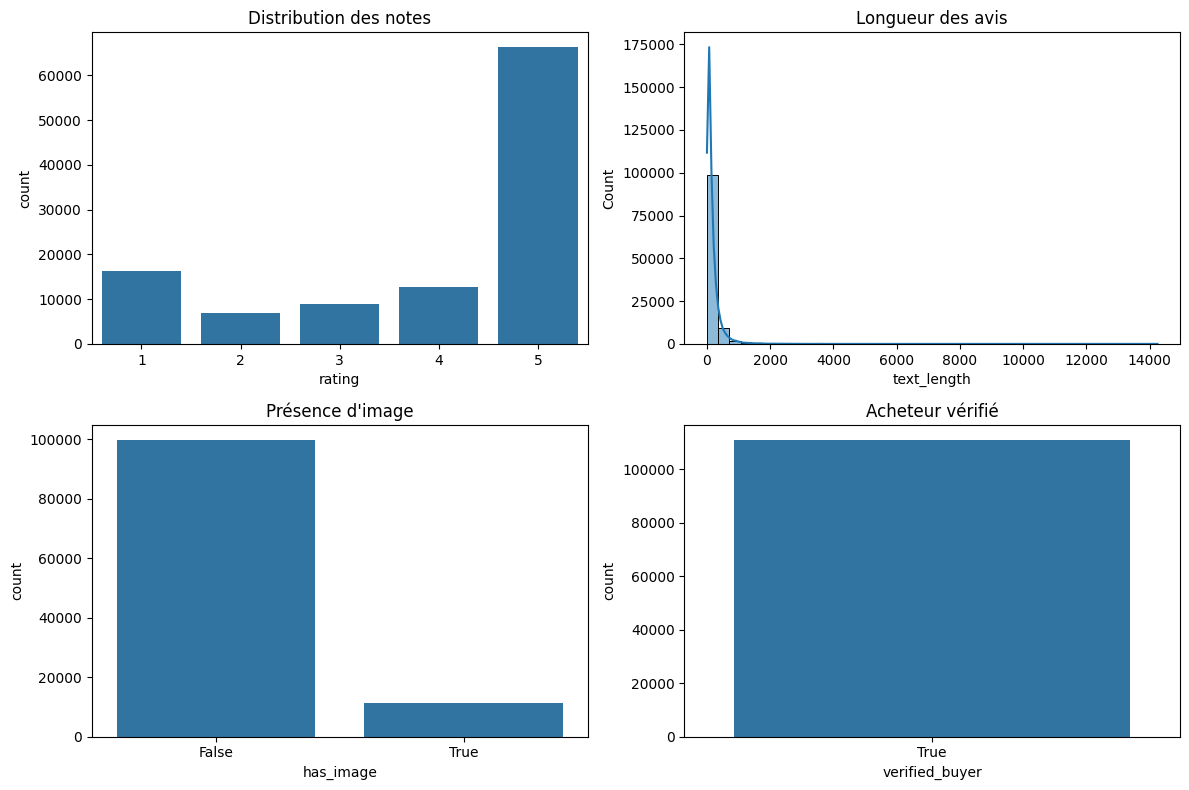

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aperçu général
print("Nombre de lignes :", len(df_reviews))

# Longueur des avis
df_reviews["text_length"] = df_reviews["review_text"].astype(str).str.len()

fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Distribution des notes
sns.countplot(data=df_reviews, x="rating", ax=axes[0,0])
axes[0,0].set_title("Distribution des notes")

# Longueur des avis
sns.histplot(df_reviews["text_length"], bins=40, kde=True, ax=axes[0,1])
axes[0,1].set_title("Longueur des avis")

# Présence d'image
sns.countplot(data=df_reviews, x="has_image", ax=axes[1,0])
axes[1,0].set_title("Présence d'image")
pct_images = df_reviews["has_image"].mean() * 100

# Acheteur vérifié
sns.countplot(data=df_reviews, x="verified_buyer", ax=axes[1,1])
axes[1,1].set_title("Acheteur vérifié")
pct_verified = df_reviews["verified_buyer"].mean() * 100

print(f"% d'avis avec image : {pct_images:.2f}%")
print(f"% d'acheteurs vérifiés : {pct_verified:.2f}%")

plt.tight_layout()
plt.show()



### 📝 Observations préliminaires (EDA)

L'exploration rapide du dataset met en évidence plusieurs points utiles pour la suite :

- **Distribution des notes très asymétrique** : la majorité des avis est notée 5, ce qui est courant dans les plateformes e-commerce.  
  → Le modèle Zero-Shot devra donc compenser ce biais en se basant davantage sur le texte que sur la note.

- **Longueur des avis très variable** : beaucoup d'avis courts (quelques dizaines de caractères) mais aussi quelques avis très longs.  
  → Le score de pertinence devra intégrer cette hétérogénéité.

- **Peu d'avis avec images** : `has_image = True` est minoritaire.  
  → Il est judicieux dans ce cas de pousser un peu l'analyse pour voir si on peut malgré tout en tirer une conclusion,  
pour nous permettre de pondérer le score de pertinence.

- **La totalité des acheteurs sont vérifiés** (`verified_buyer = True`).  
  → Tous les avis proviennent d'achats réels dans les données fournies. Le champ n'aura aucun impact sur l'analyse et ne sera donc pas utilisé dans notre cas.

Ces observations confirment que les données sont cohérentes et exploitables, et justifient le recours à une analyse NLP pour extraire les thèmes et la pertinence des avis.


## 🔍 Mini-exploration ciblée : présence d’image et note

L’objectif de cette analyse est d’évaluer si la variable `has_image` apporte une information exploitable dans la qualification des avis clients.

Dans un premier temps, nous analysons l’impact de la présence d’une image sur la **note attribuée** par l’utilisateur.


Moyenne des notes selon has_image
has_image
False    3.930338
True     4.162632
Name: rating, dtype: float64


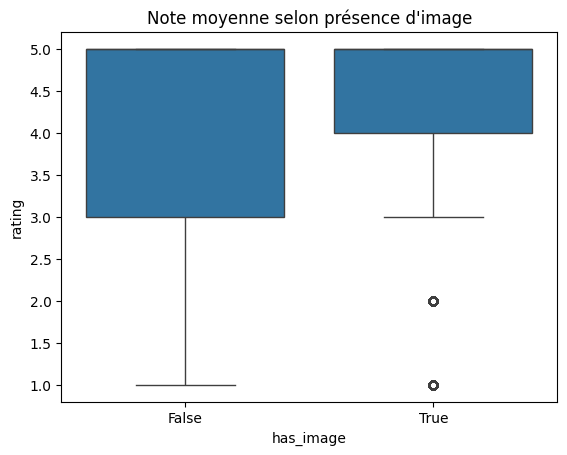

In [3]:
print("Moyenne des notes selon has_image")
print(df_reviews.groupby("has_image")["rating"].mean())

sns.boxplot(data=df_reviews, x="has_image", y="rating")
plt.title("Note moyenne selon présence d'image")
plt.show()

### ⚠️ Limite d’interprétation

Bien que les avis contenant une image présentent en moyenne une note légèrement plus élevée, cette observation ne permet **pas de conclure à une plus grande pertinence de l’avis**.

La présence d’une image reflète cependant :
- un **engagement utilisateur plus élevé**,
- un **contexte de satisfaction**,

mais ne garantit ni :
- la richesse du contenu textuel,
- ni la valeur informationnelle réelle pour un futur acheteur.

On en profite donc pour regarder la corrélation `has_image` / `text_length`

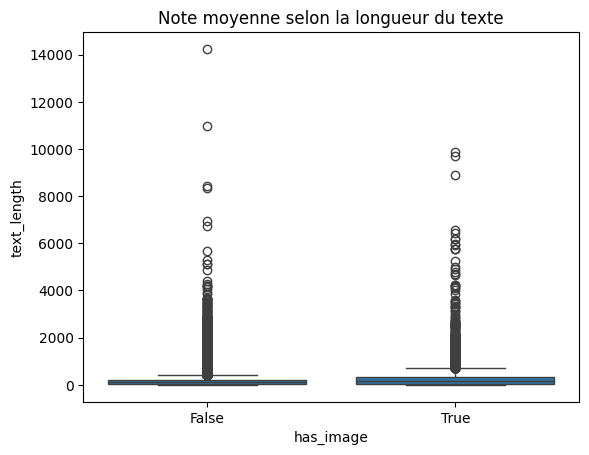

In [5]:
df_reviews["text_length"] = df_reviews["review_text"].str.len()

df_reviews.groupby("has_image")["text_length"].mean()

sns.boxplot(data=df_reviews, x="has_image", y="text_length")
plt.title("Note moyenne selon la longueur du texte")
plt.show()

### Conclusion de la mini-exploration

On observe que les avis avec image ont :  
- une médiane de longueur plus élevée  
- une dispersion plus large

Malgré que la variable `has_image` ne constitue pas un indicateur direct de pertinence à elle seule,   
combinée à la longueur du texte, elle devient un **signal utile pour estimer la valeur informationnelle d’un avis**.

Dans le cadre du calcul du `relevance_score`, la présence d’une image sera donc utilisée comme un **facteur de pondération**, renforçant l’importance des avis déjà riches sur le plan textuel


# 🧠 Classification Zero-Shot des avis

L'objectif de cette étape est d'attribuer automatiquement un **thème** à chaque avis client sans modèle entraîné, via une approche *Zero-Shot Classification*.  
Cette méthode permet de comparer chaque avis à un ensemble de catégories définies et d'identifier celle qui correspond le mieux au contenu du texte.

Nous réutilisons ici les mêmes catégories que dans le prototype afin de garantir la cohérence analytique :  
- product quality  
- delivery issue  
- customer service  
- product defect  
- general satisfaction  
- price value  
- other

Le modèle utilisé est :  
**cross-encoder/nli-distilroberta-base**, basé sur du *Natural Language Inference* (NLI).  
Au cours du projet, nous avons testé d'autres modèles (valhalla/distilbart-mnli-12-3, cross-encoder/nli-deberta-base), mais ils ne convenaient pas à notre besoin ou à notre échelle (trop lents, incompatibles, dépendances complexes, etc)



In [5]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
import torch

df_product = df_reviews
# ---------------------------------------------------
# 1. Chargement du modèle Zero-Shot 
# ---------------------------------------------------

# Utilisation du CPU si le GPU n'est pas disponible
device = 0 if torch.cuda.is_available() else -1

classifier = pipeline(
    "zero-shot-classification",
    model="valhalla/distilbart-mnli-12-3",
    device=device
)

candidate_labels = [
    "product quality",
    "delivery issue",
    "customer service",
    "product defect",
    "general satisfaction",
    "price value",
    "other"
]

# ---------------------------------------------------
# 2. Fonction Zero-Shot optimisée pour texte court
# ---------------------------------------------------

def classify_review(text):
    """
    Retourne (label_principal, score_confiance)
    Version optimisée qui :
    - ignore les textes vides
    - modèle appelé une seule fois par review
    - renvoie un score float simple
    """
    if pd.isna(text) or not text.strip():
        return None, 0.0
    
    result = classifier(
        text,
        candidate_labels,
        multi_label=False
    )
    return result["labels"][0], float(result["scores"][0])


# ---------------------------------------------------
# 3. Application sur df_product
# ---------------------------------------------------

df_target = df_product.copy()

tqdm.pandas(desc="Zero-Shot en cours")

df_target[["category", "confidence_score"]] = df_target["review_text"].progress_apply(
    lambda x: pd.Series(classify_review(x))
)

print("Zero-Shot terminé.")
df_target.head()


d:\Jedha\Projet\amazon-industry-insights\venv-amazonreviews\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cuda:0
Zero-Shot en cours: 100%|██████████| 111036/111036 [2:47:16<00:00, 11.06it/s] 

Zero-Shot terminé.


,review_id,buyer_id,product_id,title,review_text,rating,has_image,has_subscription,verified_buyer,text_length,category,confidence_score
0,96001,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,Yes!,"smells good, feels great!",5,False,False,True,25,general satisfaction,0.549547
1,96002,AE5DIA2HDWBPNGBO2FXN2PF4NQJA,B081GCFHPG,Really nice quality,these are not what i was expecting. they are s...,5,False,True,True,208,product quality,0.471467
2,96003,AEEM2QIBMUUXEAJIEQH2WT2KNZZA,B07T2L6JQR,Great product,great product,5,False,False,True,13,product quality,0.810094
3,96004,AEITH2MBDGMCSAZSBNAYOEBOJXFA,B0008F6QGO,great clipper cleaner,only 2 problems with this product expensive an...,5,False,False,True,124,delivery issue,0.192128
4,96005,AEHVSZ72XXI4SU6XUNXMJAXUYN6Q,B00JM1BZUW,Four Stars,i'm very happy with my order. will order item ...,4,False,False,True,79,product quality,0.679889


### On sauvegarde cette première version des résultats en local pour analyser dans le futur sans avoir à relancer le calcul
Une fois que l'on sera fixé sur les résultats, ils pourront être chargés dans S3 (datalake/curated)

In [6]:
df_target.to_csv("classified_reviews_v1.csv", index=False, encoding="utf-8")
print("CSV sauvegardé : classified_reviews_v1.csv")

df_target.to_parquet("classified_reviews_v1.parquet", index=False)
print("Parquet sauvegardé : classified_reviews_v1.parquet")

CSV sauvegardé : classified_reviews_v1.csv
Parquet sauvegardé : classified_reviews_v1.parquet


## 🔎 Analyse qualitative et visuelle des résultats du modèle Zero-Shot

On utilise une approche **exploratoire et qualitative**, basée sur des visualisations et des échantillons représentatifs, afin de vérifier :

- la cohérence globale des catégories prédites,
- la répartition des avis entre les classes,
- la plausibilité métier des associations *texte / catégorie*,
- le niveau de confiance associé aux prédictions.

Cette étape permet de valider que le modèle constitue une **base exploitable** pour des usages analytiques et décisionnels, avant toute itération ou amélioration.


---

### 📊 Distribution des catégories prédites

La visualisation ci-dessous permet d’observer la répartition des avis entre les différentes catégories Zero-Shot.

Une distribution trop déséquilibrée ou incohérente pourrait révéler :
- un problème de formulation des labels,
- un biais dans les données sources,
- ou une mauvaise adéquation entre les catégories choisies et les contenus réels des avis.

À l’inverse, une répartition plausible et diversifiée constitue un premier indicateur de bon fonctionnement du modèle.

---

### 🧪 Vérification qualitative par échantillonnage

Afin de compléter l’analyse quantitative, nous inspectons manuellement quelques exemples d’avis par catégorie.

Pour chaque catégorie, nous observons :
- le contenu textuel de l’avis,
- la note associée,
- le score de confiance du modèle.

Cette analyse qualitative permet de juger si les prédictions sont :
- sémantiquement pertinentes,
- compréhensibles d’un point de vue métier,
- et suffisamment fiables pour être utilisées comme base d’enrichissement des données.

➡️ df_target non trouvé, chargement du fichier : classified_reviews_v1.parquet
✔️ df_target chargé avec succès.


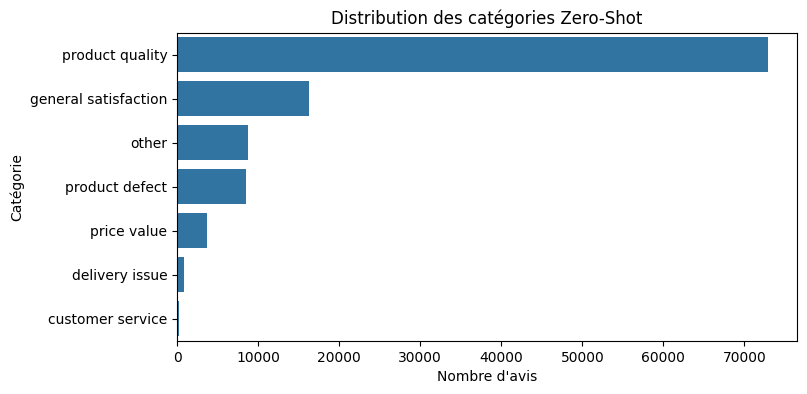

,category,rating,confidence,text
0,general satisfaction,5,0.550,"smells good, feels great!"
1,general satisfaction,5,0.467,happy i can still find these for my mom good q...
2,product quality,5,0.471,these are not what i was expecting. they are s...
3,product quality,5,0.810,great product
4,delivery issue,5,0.192,only 2 problems with this product expensive an...
5,delivery issue,5,0.335,love the quality of this item. great price. i ...
6,customer service,3,0.253,i promised to retract the negative review once...
7,customer service,5,0.453,love this ! great service too
8,other,5,0.174,"so, for a man who thinks his looks strike a re..."
9,other,1,0.573,this is a joke. they do not work. do not waste...


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os


# --------------------------------------------------------------------
# 0) Récupération si besoin des données traitées par le zero shot
# --------------------------------------------------------------------
if "df_target" in globals():
    print("➡️ df_target déjà en mémoire, utilisation du DataFrame existant.")
else:
    parquet_path = "classified_reviews_v1.parquet"

    if os.path.exists(parquet_path):
        print(f"➡️ df_target non trouvé, chargement du fichier : {parquet_path}")
        df_target = pd.read_parquet(parquet_path)
        print("✔️ df_target chargé avec succès.")
    else:
        raise FileNotFoundError(
            f"❌ Impossible de continuer : ni df_target en mémoire, ni fichier '{parquet_path}' trouvé."
        )

df_target = df_target.rename(columns={"confidence": "confidence_score"})


# --------------------------------------------------------------------
# 1) Distribution des catégories Zero-Shot
# --------------------------------------------------------------------
plt.figure(figsize=(8,4))
sns.countplot(
    data=df_target,
    y="category",
    order=df_target["category"].value_counts().index
)
plt.title("Distribution des catégories Zero-Shot")
plt.xlabel("Nombre d'avis")
plt.ylabel("Catégorie")
plt.show()  

# --------------------------------------------------------------------
# 4) Exemples d'avis par catégorie
# --------------------------------------------------------------------
def sample_reviews_by_category(df, n=2, max_chars=200):
    """
    Retourne un petit tableau d'exemples (n par catégorie),
    avec un texte limité pour rester lisible.
    """
    exemples = []

    for cat in df["category"].dropna().unique():
        subset = df[df["category"] == cat].head(n)
        for _, row in subset.iterrows():
            text = row["review_text"]
            if len(text) > max_chars:
                text = text[:max_chars] + "…"

            exemples.append({
                "category": cat,
                "rating": row["rating"],
                "confidence": round(row["confidence_score"], 3),
                "text": text
            })
    
    return pd.DataFrame(exemples)

df_examples = sample_reviews_by_category(df_target, n=2)
df_examples


## ⚠️ Analyse critique du modèle Zero-Shot (Version 1)

L’analyse de la distribution des catégories et l’inspection manuelle de plusieurs exemples révèlent certaines limites du modèle Zero-Shot dans sa configuration actuelle.

Plusieurs constats ressortent :

- La catégorie **`product quality`** concentre une part très majoritaire des avis, ce qui suggère une **sur-généralisation** de cette classe.
- Certaines catégories métier importantes (`delivery issue`, `customer service`, `price value`) sont très peu représentées, alors qu’elles sont attendues comme récurrentes dans les avis.
- Les scores de confiance associés à certaines prédictions restent relativement faibles ou hétérogènes, y compris pour des avis courts et explicites.
- La catégorie other n'a pas lieu d'être, on préfère un avis dans une autre catégorie avec un indice de confiance faible plutôt que toute une catégorie other qu'on ne pourra pas valoriser

Ces éléments indiquent que la performance du modèle dépend fortement du **choix des catégories proposées**, et que la première version ne permet pas encore une segmentation suffisamment discriminante et exploitable d’un point de vue métier.


## 🔁 Modèle Zero-Shot – Version 2 (V2)

Suite aux limites observées avec la première configuration du modèle Zero-Shot, nous proposons une **seconde itération** visant à améliorer la lisibilité métier et la capacité de discrimination des catégories.

### 🎯 Objectifs de cette nouvelle configuration

Cette version a été conçue pour :
- **Réduire la sur-représentation** de catégories trop génériques,
- Séparer plus clairement les **dimensions émotionnelles** (expérience positive / négative) des **problèmes fonctionnels** (qualité, défaut, livraison),
- Mieux capter les signaux exploitables pour des cas d’usage concrets (qualité produit, logistique, perception du prix).

### 🧠 Modèle utilisé
On profite d'une nouvelle itération pour tester un nouveau modèle, `facebook/bart-large-mnli`, ce qui nous permettra également de comparer les performances avec les résultats sur différents modèles

### 🏷️ Nouvelle liste de catégories (V2)

La liste des labels a été repensée pour être :
- plus explicite,
- moins ambiguë,
- directement exploitable par les équipes métier.

```python
candidate_labels = [
    "product quality",
    "product defect",
    "positive experience",
    "negative experience",
    "delivery issue",
    "delivery satisfaction",
    "price value"
]

In [ ]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
import torch

df_product = df_reviews
# ---------------------------------------------------
# 1. Chargement du modèle Zero-Shot 
# ---------------------------------------------------

# Utilisation du CPU si le GPU n'est pas disponible
device = 0 if torch.cuda.is_available() else -1

classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device
)

candidate_labels = [
    "product quality",
    "product defect",
    "positive experience",
    "negative experience",
    "delivery issue",
    "delivery satisfaction",
    "price value"
]

# ---------------------------------------------------
# 2. Fonction Zero-Shot optimisée pour texte court
# ---------------------------------------------------

def classify_review(text):
    """
    Retourne (label_principal, score_confiance)
    Version optimisée qui :
    - ignore les textes vides
    - modèle appelé une seule fois par review
    - renvoie un score float simple
    """
    if pd.isna(text) or not text.strip():
        return None, 0.0
    
    result = classifier(
        text,
        candidate_labels,
        multi_label=False
    )
    return result["labels"][0], float(result["scores"][0])


# ---------------------------------------------------
# 3. Application sur df_product
# ---------------------------------------------------

df_target = df_product.copy()

tqdm.pandas(desc="Zero-Shot en cours")

df_target[["category", "confidence_score"]] = df_target["review_text"].progress_apply(
    lambda x: pd.Series(classify_review(x))
)

print("Zero-Shot terminé.")
df_target.head()


Device set to use cuda:0
Zero-Shot en cours: 100%|██████████| 111036/111036 [3:03:52<00:00, 10.06it/s] 

Zero-Shot terminé.


,review_id,buyer_id,product_id,title,review_text,rating,has_image,has_subscription,verified_buyer,text_length,category,confidence_score
0,96001,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,Yes!,"smells good, feels great!",5,False,False,True,25,positive experience,0.883954
1,96002,AE5DIA2HDWBPNGBO2FXN2PF4NQJA,B081GCFHPG,Really nice quality,these are not what i was expecting. they are s...,5,False,True,True,208,product quality,0.587857
2,96003,AEEM2QIBMUUXEAJIEQH2WT2KNZZA,B07T2L6JQR,Great product,great product,5,False,False,True,13,positive experience,0.508243
3,96004,AEITH2MBDGMCSAZSBNAYOEBOJXFA,B0008F6QGO,great clipper cleaner,only 2 problems with this product expensive an...,5,False,False,True,124,negative experience,0.480251
4,96005,AEHVSZ72XXI4SU6XUNXMJAXUYN6Q,B00JM1BZUW,Four Stars,i'm very happy with my order. will order item ...,4,False,False,True,79,positive experience,0.674372


### On sauvegarde également cette deuxième version des résultats en local pour analyser dans le futur sans avoir à relancer le calcul
Une fois que l'on sera fixé sur le modèle et la liste à utiliser, les résultats pourront être chargés dans S3 (datalake/curated)

In [ ]:
df_target.to_csv("classified_reviews_v2.csv", index=False, encoding="utf-8")
print("CSV sauvegardé : classified_reviews_v2.csv")

df_target.to_parquet("classified_reviews_v2.parquet", index=False)
print("Parquet sauvegardé : classified_reviews_v2.parquet")

CSV sauvegardé : classified_reviews_v2.csv
Parquet sauvegardé : classified_reviews_v2.parquet


➡️ df_target non trouvé, chargement du fichier : classified_reviews_v2.parquet
✔️ df_target chargé avec succès.


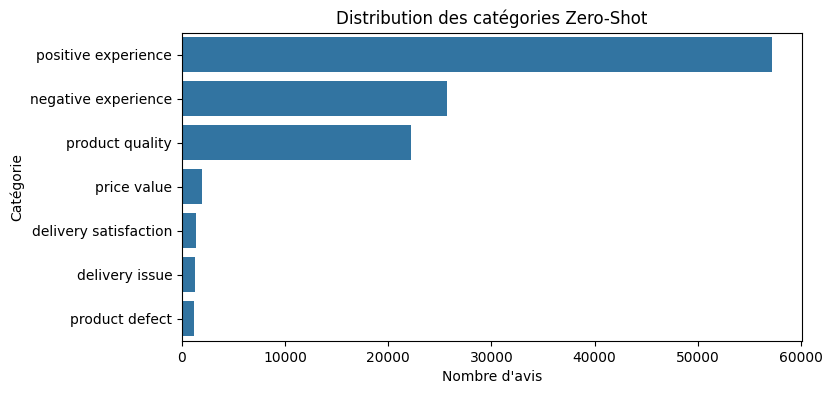

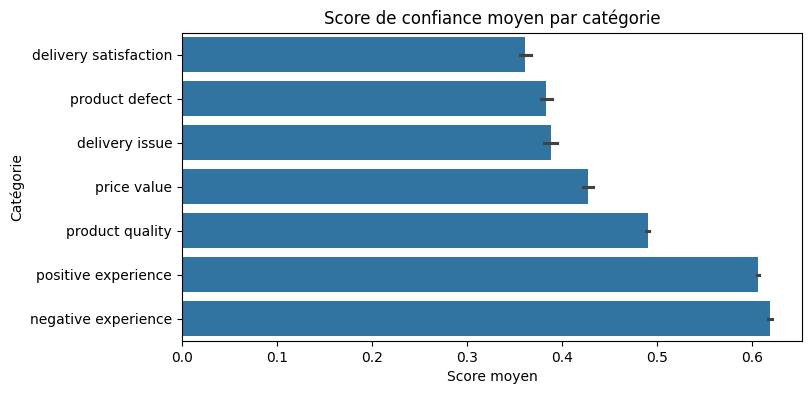

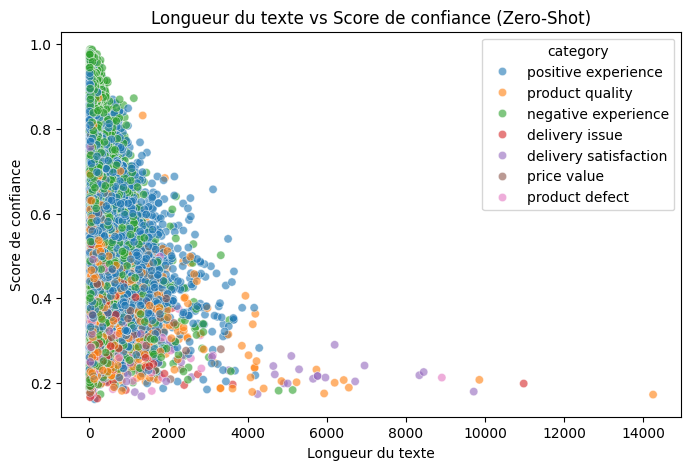

,category,rating,confidence,text
0,positive experience,5,0.884,"smells good, feels great!"
1,positive experience,5,0.508,great product
2,product quality,5,0.588,these are not what i was expecting. they are s...
3,product quality,5,0.410,"i bought one and after trying it, i bought thr..."
4,negative experience,5,0.480,only 2 problems with this product expensive an...
5,negative experience,3,0.573,i promised to retract the negative review once...
6,delivery issue,1,0.417,20 minutes of fragrance nothing more. 30 plus ...
7,delivery issue,5,0.362,i had a set of headbands just like these in th...
8,delivery satisfaction,3,0.285,to strong for my liking so i have to my daught...
9,delivery satisfaction,5,0.312,i ordered these as replacements. they arrived ...


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

# --------------------------------------------------------------------
# 0) Récupération si besoin des données traitées par le zero shot
# --------------------------------------------------------------------
if "df_target" in globals():
    print("➡️ df_target déjà en mémoire, utilisation du DataFrame existant.")
else:
    parquet_path = "classified_reviews_v2.parquet"

    if os.path.exists(parquet_path):
        print(f"➡️ df_target non trouvé, chargement du fichier : {parquet_path}")
        df_target = pd.read_parquet(parquet_path)
        print("✔️ df_target chargé avec succès.")
    else:
        raise FileNotFoundError(
            f"❌ Impossible de continuer : ni df_target en mémoire, ni fichier '{parquet_path}' trouvé."
        )

df_target = df_target.rename(columns={"confidence": "confidence_score"})


# --------------------------------------------------------------------
# 1) Distribution des catégories Zero-Shot
# --------------------------------------------------------------------
plt.figure(figsize=(8,4))
sns.countplot(
    data=df_target,
    y="category",
    order=df_target["category"].value_counts().index
)
plt.title("Distribution des catégories Zero-Shot")
plt.xlabel("Nombre d'avis")
plt.ylabel("Catégorie")
plt.show()

# --------------------------------------------------------------------
# 2) Score de confiance moyen par catégorie
# --------------------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(
    data=df_target,
    x="confidence_score",
    y="category",
    order=df_target.groupby("category")["confidence_score"].mean().sort_values().index
)
plt.title("Score de confiance moyen par catégorie")
plt.xlabel("Score moyen")
plt.ylabel("Catégorie")
plt.show()

# --------------------------------------------------------------------
# 3) Longueur du texte vs score de confiance
# --------------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_target,
    x="text_length",
    y="confidence_score",
    hue="category",
    alpha=0.6
)
plt.title("Longueur du texte vs Score de confiance (Zero-Shot)")
plt.xlabel("Longueur du texte")
plt.ylabel("Score de confiance")
plt.show()

# --------------------------------------------------------------------
# 4) Exemples d'avis par catégorie
# --------------------------------------------------------------------
def sample_reviews_by_category(df, n=2, max_chars=200):
    """
    Retourne un petit tableau d'exemples (n par catégorie),
    avec un texte limité pour rester lisible.
    """
    exemples = []

    for cat in df["category"].dropna().unique():
        subset = df[df["category"] == cat].head(n)
        for _, row in subset.iterrows():
            text = row["review_text"]
            if len(text) > max_chars:
                text = text[:max_chars] + "…"

            exemples.append({
                "category": cat,
                "rating": row["rating"],
                "confidence": round(row["confidence_score"], 3),
                "text": text
            })
    
    return pd.DataFrame(exemples)

df_examples = sample_reviews_by_category(df_target, n=2)
df_examples


### 🧩 Conclusion de l’analyse Zero-Shot

L’analyse Zero-Shot appliquée au produit met en évidence une **forte polarisation des avis autour de l’expérience utilisateur**, davantage que sur des dimensions fonctionnelles précises.

1. **La catégorie largement dominante est _positive experience_**, suivie de près par **_negative experience_**.  
   Cela indique que le modèle capte prioritairement la tonalité émotionnelle globale des avis.  
   La catégorie **_product quality_**, bien que significative, arrive en troisième position.

2. **Les catégories spécifiques** telles que _product defect_, _delivery issue_, _delivery satisfaction_ et _price value_ **apparaissent de manière marginale**.  
   Cela suggère soit une faible occurrence réelle de ces thèmes, soit une difficulté du Zero-Shot à les isoler lorsqu’ils ne sont pas explicitement formulés.

3. **Les scores de confiance moyens varient significativement selon les catégories** :
   - Les catégories émotionnelles (_positive_ / _negative experience_) obtiennent les **scores de confiance les plus élevés** (vers 0.6),
   - Les catégories factuelles ou logistiques présentent des **scores plus faibles** (vers 0.4), traduisant une frontière sémantique plus floue.

4. **La relation entre la longueur des avis et le score de confiance confirme le comportement attendu du modèle** :
   - Les avis **courts et explicites** sont classés avec une confiance élevée,
   - Les avis **courts mais peu informatifs** génèrent une confiance plus faible,
   - Les avis **longs** présentent une forte variance, liée à la coexistence de plusieurs thèmes concurrents,
   - Les avis **très longs** présentent un score de confiance trop faible pour être exploités (vers 0.2).

5. **Les exemples d’avis par catégorie confirment qualitativement la cohérence des prédictions**, tout en mettant en évidence une tendance du Zero-Shot à privilégier des catégories génériques dès que le signal thématique devient ambigu.

Dans l’ensemble, le Zero-Shot fournit une **segmentation macro-thématique robuste**, mais principalement **orientée vers la polarité de l’expérience**.

Cette catégorisation constitue un socle pertinent pour la construction d’un **`relevance_score`**, à condition :
- de pondérer fortement la confiance du modèle,
- de corriger le biais en faveur des catégories émotionnelles,
- et de réintroduire des signaux structurants (note, longueur du texte, métadonnées).


# 🧮 Construction du relevance_score

L'objectif de cette section est d'identifier les avis les plus utiles et les plus informatifs des différents produits.  
Si la classification Zero-Shot permet de déterminer le thème principal de chaque avis, elle ne suffit pas à évaluer sa pertinence globale : certains avis courts ou vagues sont correctement catégorisés, mais apportent peu d'informations, tandis que d'autres avis plus longs ou plus détaillés peuvent être très précieux pour les équipes produit ou pour les autres clients.

Pour cette raison, nous construisons un **relevance_score**, un indicateur qui :
- valorise les avis détaillés, explicatifs et riches en informations;
- prend en compte la fiabilité du Zero-Shot via le score de confiance;
- pondère avec des métadonnées (image, achat vérifié, abonnement actif);
- atténue l'effet des avis courts ou peu informatifs, même s'ils sont correctement catégorisés.

Ce score synthétise plusieurs aspects du contenu (texte, thème, confiance, métadonnées) afin de repérer les avis les plus pertinents pour un usage métier (ex: mise en avant sur la fiche produit, détection de problèmes qualité, analyse des retours clients, etc).

Nous allons maintenant définir précisément la logique du relevance_score avant de l'appliquer à l'ensemble des avis.


In [23]:
import numpy as np

df_score = df_target.copy()

# -------------------------------
# Calcul du relevance_score
# -------------------------------

df_score["relevance_score"] = (
    # Confiance Zero-Shot (pondération principale)
    0.40 * df_score["confidence_score"] +
    
    # Longueur du texte normalisée
    0.25 * (df_score["text_length"] / df_score["text_length"].max()) +
    
    # Note valorisée si dans les extrêmes
    0.15 * (abs(df_score["rating"] - 3) / 2) +
    
    # Métadonnées pondérées
    df_score["has_image"].astype(int) * 0.05 +
    df_score["verified_buyer"].astype(int) * 0.05 +
    df_score["has_subscription"].astype(int) * 0.10
)

# Tri par pertinence décroissante
df_score = df_score.sort_values("relevance_score", ascending=False)

# Aperçu des 10 avis les plus pertinents
df_score[[
    "review_text",
    "rating",
    "category",
    "confidence_score",
    "relevance_score"
]].head(10)


,review_text,rating,category,confidence_score,relevance_score
81459,one of my many favorits,5,positive experience,0.975750,0.740703
731,so far so good! loving the beachy waves it gives me! curls holding for about 6 hours with no product.,5,positive experience,0.962115,0.736618
65671,hair tangled it s horrible !! no amount of products bounce this hair back to life.,1,negative experience,0.961017,0.735846
110049,its good so far,5,positive experience,0.962607,0.735306
80215,"comodidad y buen manejo, muy encantada",5,positive experience,0.961116,0.735113
74820,videoid 89689181b73382d00d31d58973272bc3 this is not human hair at all and i am very disappointed. i need a refund do not buy these bundles false advertising. if i could zero star i would,1,negative experience,0.952310,0.734205
104721,do y'all see what i'm looking at? gross,1,negative experience,0.956899,0.733444
97339,this has my face feeling soooo good..,5,positive experience,0.955938,0.733024
80161,garbage,1,negative experience,0.953510,0.731527
101555,bald spots better! works good!,5,positive experience,0.948976,0.730117


### 🔍 Sélection des avis les plus pertinents

À partir des signaux disponibles (thème détecté en Zero-Shot, score de confiance, longueur du texte, intensité de la note et métadonnées), un **`relevance_score` composite** a été calculé afin d’identifier les avis les plus informatifs.

Les avis présentés au dessus correspondent aux **scores de pertinence les plus élevés**.  
On observe que ce classement fait émerger :
- des avis **très confiants** du point de vue du modèle,
- des **opinions marquées** (positives ou négatives),
- et des textes apportant un **signal exploitable**, indépendamment de la polarité.

La visualisation ci dessous permet d’analyser la distribution et les caractéristiques de ces avis à forte pertinence.


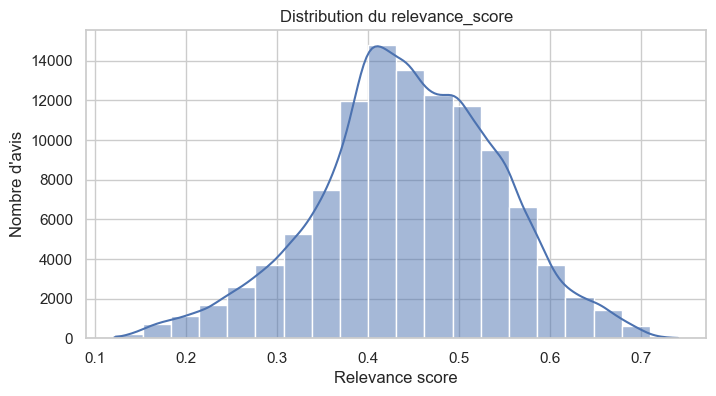

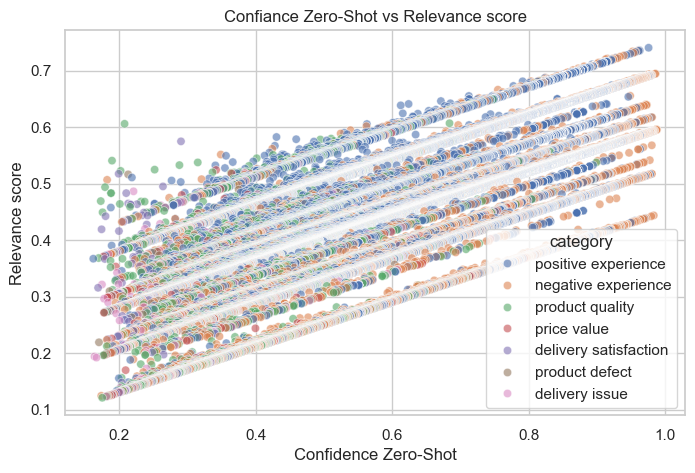

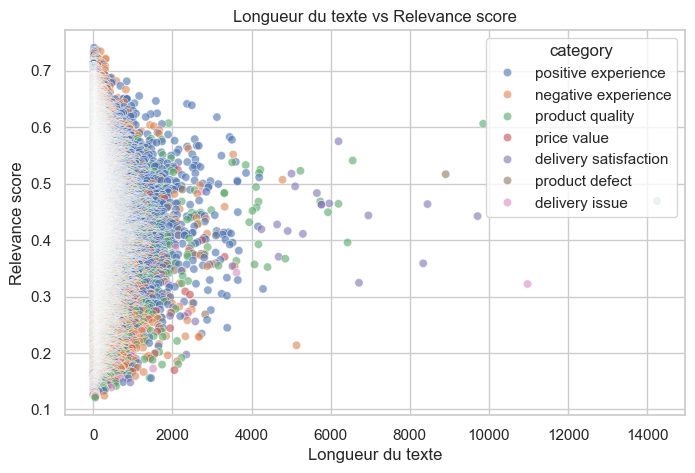

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Style global
sns.set(style="whitegrid")

# --------------------------------------------------------
# 1) Distribution du relevance_score
# --------------------------------------------------------
plt.figure(figsize=(8,4))
sns.histplot(df_score["relevance_score"], bins=20, kde=True)
plt.title("Distribution du relevance_score")
plt.xlabel("Relevance score")
plt.ylabel("Nombre d'avis")
plt.show()

# --------------------------------------------------------
# 2) Scatter : Zero-Shot confidence vs relevance_score
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_score,
    x="confidence_score",
    y="relevance_score",
    hue="category",
    alpha=0.6
)
plt.title("Confiance Zero-Shot vs Relevance score")
plt.xlabel("Confidence Zero-Shot")
plt.ylabel("Relevance score")
plt.show()

# --------------------------------------------------------
# 3) Scatter : Longueur du texte vs relevance_score
# --------------------------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_score,
    x="text_length",
    y="relevance_score",
    hue="category",
    alpha=0.6
)
plt.title("Longueur du texte vs Relevance score")
plt.xlabel("Longueur du texte")
plt.ylabel("Relevance score")
plt.show()


### 🧩 Interprétation du relevance_score

1. **Distribution du relevance_score**  
   La majorité des avis se concentre entre **0,30 et 0,55**, avec un pic situé autour de **0,40–0,45**.  
   Les scores très élevés (> 0,65) sont rares, tandis que les scores très faibles restent marginaux.  

   → Le relevance_score agit comme un **filtre discriminant**, en réservant les scores élevés à un nombre limité d’avis réellement informatifs.

2. **Lien entre confiance Zero-Shot et relevance_score**  
   Le nuage de points met en évidence une **corrélation forte et structurante** entre la confiance du modèle Zero-Shot et le relevance_score.  
   Toutefois, la dispersion observée pour un même niveau de confiance montre que le score final intègre effectivement d’autres signaux :  
   - longueur du texte,  
   - intensité de la note,  
   - métadonnées (image, achat vérifié, abonnement).

   → Le relevance_score ne se contente pas de reproduire la confiance Zero-Shot ; il la **module**.

3. **Lien entre longueur du texte et relevance_score**  
   La majorité des avis sont courts, mais couvrent une large plage de scores.  
   Les avis plus longs bénéficient d’un **plafond de score plus élevé**, sans pour autant dominer systématiquement le classement.  

   → La longueur agit comme un **facteur de soutien**, mais ne devient pas un critère dominant au détriment de la confiance ou du contenu sémantique.

Dans l’ensemble, ces visualisations montrent que le relevance_score est **équilibré et hiérarchisant** :  
il favorise les avis à fort signal sémantique et forte intensité, sans survaloriser mécaniquement ni la longueur, ni la polarité, ni la confiance prise isolément.


In [25]:
df_target['confidence_score'].describe()


count    111036.000000
mean          0.575044
std           0.165423
min           0.161945
25%           0.459236
50%           0.557768
75%           0.688638
max           0.987989
Name: confidence_score, dtype: float64

### 📊 Distribution du score de confiance Zero-Shot

Les statistiques descriptives du **`confidence_score`** permettent d’évaluer la **disparité des prédictions du modèle Zero-Shot**.

- Le score moyen est de **0,58**, indiquant une confiance globalement modérée.
- L’écart-type (**0,17**) révèle une **variabilité significative** entre les avis.
- Les quartiles montrent une dispersion claire :
  - 25 % des avis ont une confiance inférieure à **0,46**,
  - 50 % sont en dessous de **0,56** (médiane),
  - 25 % dépassent **0,69**.
- Les valeurs extrêmes s’étendent de **0,16** à **0,99**, traduisant des prédictions allant de très incertaines à quasi certaines.

→ Cette hétérogénéité justifie l’intégration du score de confiance comme **signal central** dans le calcul du `relevance_score`, afin de différencier les avis à faible signal sémantique de ceux pour lesquels le modèle est réellement confiant.


In [26]:
import textwrap

def show_reviews(df, n=5, title=""):
    print(f"\n=== {title} ===\n")
    df = df.copy()

    # Étendre le texte (200 caractères max)
    pd.set_option('display.max_colwidth', None)
    df["review_text"] = df["review_text"].apply(
        lambda t: "\n".join(textwrap.wrap(str(t), width=100))
    )

    display(df[[
        "category",
        "review_text",
        "rating",
        "confidence_score",
        "text_length",
        "relevance_score"
    ]])

# Trier
df_sorted = df_score.sort_values(by="relevance_score", ascending=False)

# Top 5
show_reviews(df_sorted.head(5), title="TOP 5 AVIS LES PLUS PERTINENTS")

# Bottom 5
show_reviews(df_sorted.tail(5), title="BOTTOM 5 AVIS LES MOINS PERTINENTS")



=== TOP 5 AVIS LES PLUS PERTINENTS ===



,category,review_text,rating,confidence_score,text_length,relevance_score
81459,positive experience,one of my many favorits,5,0.975750,23,0.740703
731,positive experience,so far so good! loving the beachy waves it gives me! curls holding for about 6 hours with no\nproduct.,5,0.962115,101,0.736618
65671,negative experience,hair tangled it s horrible !! no amount of products bounce this hair back to life.,1,0.961017,82,0.735846
110049,positive experience,its good so far,5,0.962607,15,0.735306
80215,positive experience,"comodidad y buen manejo, muy encantada",5,0.961116,38,0.735113



=== BOTTOM 5 AVIS LES MOINS PERTINENTS ===



,category,review_text,rating,confidence_score,text_length,relevance_score
29195,price value,i am not sure i see a big difference.,3,0.183464,37,0.124035
24134,negative experience,not the color in the pic. this looks red on.,3,0.182271,44,0.123681
7097,product quality,the color of the outside was white not black,3,0.181979,44,0.123564
56575,delivery issue,still trying to figure out the best way to use this,3,0.180893,51,0.123252
51381,product quality,"i dunno. could be fake, could be real, who knows.",3,0.175052,49,0.120880


## 🔍 Analyse : comparaison des avis les plus pertinents et les moins pertinents

La comparaison entre les avis extrêmes permet de valider empiriquement le fonctionnement du **`relevance_score`**, en confrontant le score aux contenus réels des avis.

---

### ⭐ Avis les plus pertinents (Top 5)

Les avis les mieux classés présentent plusieurs caractéristiques communes :

- **Confiance Zero-Shot très élevée** (≈ 0.95–0.98), indiquant une catégorisation claire et non ambiguë.
- **Opinions marquées**, positives ou négatives, cohérentes avec le contenu textuel.
- **Contenu explicite**, même lorsque le texte est court : le message est clair, direct et sans ambiguïté.
- **Notes extrêmes (1★ ou 5★)** reflétant une forte intensité d’expérience.

→ Ces avis apportent un **signal informationnel fort**, indépendamment de leur longueur absolue.

---

### ⚠️ Avis les moins pertinents (Bottom 5)

Les avis les plus faibles montrent des tendances inverses :

- **Confiance Zero-Shot faible** (≈ 0.17–0.18), traduisant une difficulté du modèle à identifier un thème dominant.
- **Notes neutres (3★)**, associées à des opinions peu tranchées.
- **Contenu vague ou descriptif**, sans élément précis d’évaluation ou d’expérience utilisateur.
- **Longueur modérée mais peu informative**, suggérant que la quantité de texte ne garantit pas la pertinence.

→ Leur faible score s’explique principalement par un **manque de signal sémantique clair**, plus que par la longueur ou la polarité.

---

### 🧠 Conclusion

Cette comparaison montre que le **`relevance_score`** :

- valorise efficacement la **clarté et l’intensité du message**,
- s’appuie fortement sur la **confiance Zero-Shot**, sans s’y réduire,
- ne survalorise ni la longueur du texte ni les avis positifs,
- distingue clairement les avis réellement informatifs des avis ambigus ou peu exploitables.

Le score est donc **cohérent, discriminant et aligné avec un objectif de mise en avant des avis utiles**.


## 📊 Visualisations orientées métier

Après avoir validé le calcul et la cohérence du `relevance_score` d’un point de vue méthodologique et qualitatif, cette section vise à en évaluer **l’apport concret d’un point de vue métier**.

Les visualisations suivantes cherchent à répondre à des questions opérationnelles :
- quels avis méritent d’être mis en avant sur une page produit ?
- le score permet-il de dépasser une lecture basée uniquement sur la note ou le volume ?
- quels types d’avis émergent réellement parmi les plus pertinents ?

L’objectif est de traduire le score en **insights exploitables** pour un contexte e-commerce.


### 📊 Top avis : relevance_score vs logique basée sur la note

Cette visualisation compare les avis mis en avant par le `relevance_score` avec ceux qui seraient sélectionnés selon une logique classique basée uniquement sur la note.

L’objectif est d’illustrer concrètement **ce que le relevance_score fait émerger différemment**, en termes de contenu et de valeur informationnelle.

In [32]:
# Top 10 avis par relevance_score
top_relevance = df_score.sort_values(
    "relevance_score", ascending=False
).head(10)

# Top 10 avis par note (rating), puis confiance
top_rating = df_score.sort_values(
    ["rating", "confidence_score"], ascending=False
).head(10)

display(top_relevance[[
    "review_text", "rating", "category",
    "confidence_score", "relevance_score"
]])

display(top_rating[[
    "review_text", "rating", "category",
    "confidence_score", "relevance_score"
]])


,review_text,rating,category,confidence_score,relevance_score
81459,one of my many favorits,5,positive experience,0.975750,0.740703
731,so far so good! loving the beachy waves it gives me! curls holding for about 6 hours with no product.,5,positive experience,0.962115,0.736618
65671,hair tangled it s horrible !! no amount of products bounce this hair back to life.,1,negative experience,0.961017,0.735846
110049,its good so far,5,positive experience,0.962607,0.735306
80215,"comodidad y buen manejo, muy encantada",5,positive experience,0.961116,0.735113
74820,videoid 89689181b73382d00d31d58973272bc3 this is not human hair at all and i am very disappointed. i need a refund do not buy these bundles false advertising. if i could zero star i would,1,negative experience,0.952310,0.734205
104721,do y'all see what i'm looking at? gross,1,negative experience,0.956899,0.733444
97339,this has my face feeling soooo good..,5,positive experience,0.955938,0.733024
80161,garbage,1,negative experience,0.953510,0.731527
101555,bald spots better! works good!,5,positive experience,0.948976,0.730117


,review_text,rating,category,confidence_score,relevance_score
59900,perfect customer service,5,positive experience,0.981958,0.593204
81297,best highlight ever,5,positive experience,0.980874,0.592683
96478,great customer service,5,positive experience,0.978993,0.591983
2526,very good case,5,positive experience,0.978925,0.591816
23747,baddie!!!,5,negative experience,0.978873,0.591707
33448,great case,5,positive experience,0.978681,0.691648
36872,so far so good,5,positive experience,0.977880,0.691398
5849,so far so good,5,positive experience,0.977880,0.691398
85104,so far so good,5,positive experience,0.977880,0.591398
78524,so far so good,5,positive experience,0.977880,0.591398


### 📈 Relation entre note et pertinence

Cette visualisation permet d’analyser le lien entre la note attribuée par l’utilisateur et le `relevance_score`.

Elle vise à vérifier que la pertinence ne se confond pas avec la polarité, et que les avis négatifs peuvent constituer une source d’information essentielle.


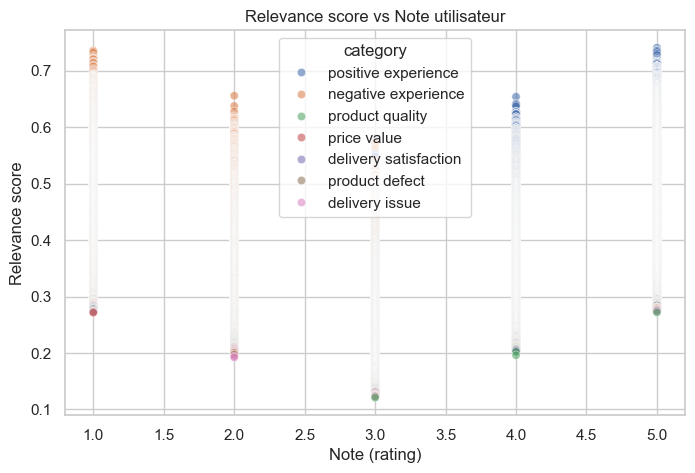

In [33]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_score,
    x="rating",
    y="relevance_score",
    hue="category",
    alpha=0.6
)
plt.title("Relevance score vs Note utilisateur")
plt.xlabel("Note (rating)")
plt.ylabel("Relevance score")
plt.show()


### 🎯 Définition d’un seuil opérationnel de pertinence

Afin de rendre le `relevance_score` exploitable opérationnellement, un seuil à > 0.6 est introduit pour distinguer les avis réellement utiles des avis à faible valeur informationnelle.


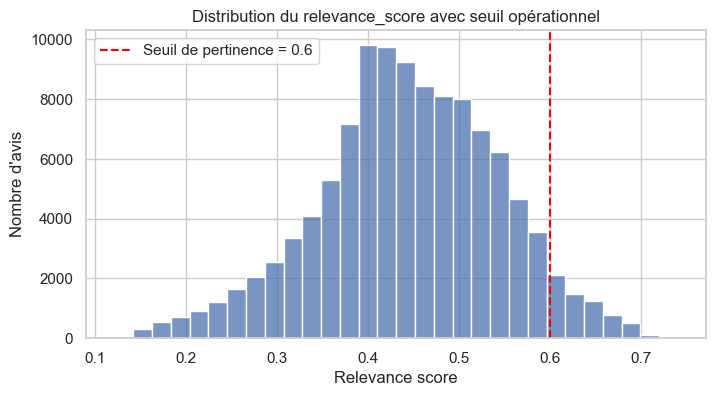

Proportion d'avis au-dessus du seuil de pertinence :


'5.2%'

In [41]:
threshold = 0.6

plt.figure(figsize=(8,4))
sns.histplot(df_score["relevance_score"], bins=30)
plt.axvline(
    threshold, color="red", linestyle="--",
    label=f"Seuil de pertinence = {threshold}"
)
plt.title("Distribution du relevance_score avec seuil opérationnel")
plt.xlabel("Relevance score")
plt.ylabel("Nombre d'avis")
plt.legend()
plt.show()

# Proportion d'avis au-dessus du seuil
print("Proportion d'avis au-dessus du seuil de pertinence :",)
'{:.1%}'.format((df_score["relevance_score"] >= threshold).mean())

## 🧮 Disponibilité d’avis pertinents


Cette analyse vise à répondre à la question suivante :  
*Tous les produits disposent-ils d’au moins un avis pertinent à afficher ?*

Autrement dit, on cherche à quantifier :
- les produits pour lesquels le score permet de mettre en avant au moins un avis utile,
- et ceux pour lesquels **aucun avis ne dépasse le seuil de pertinence**, ce qui constitue un intérêt métier moins important.


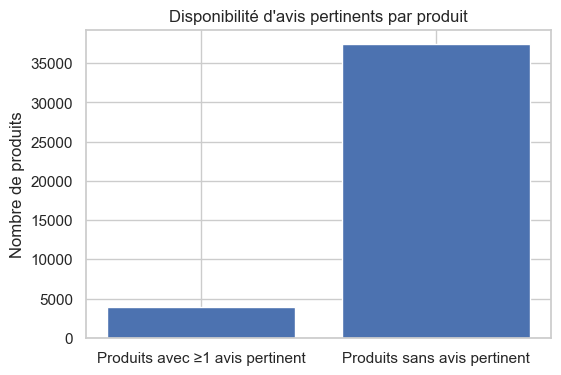

Seuil 0.45 → 24518 produits avec ≥1 avis pertinent
Seuil 0.50 → 17006 produits avec ≥1 avis pertinent
Seuil 0.55 → 9284 produits avec ≥1 avis pertinent
Seuil 0.60 → 3920 produits avec ≥1 avis pertinent


In [46]:
# Seuil opérationnel retenu
threshold = 0.6

# Nombre d'avis pertinents par produit
relevant_reviews_per_product = (
    df_score[df_score["relevance_score"] >= threshold]
    .groupby("product_id")
    .size()
    .rename("n_relevant_reviews")
)

# Nombre total de produits
total_products = df_score["product_id"].nunique()

# Produits avec au moins un avis pertinent
products_with_relevant = relevant_reviews_per_product.count()

# Produits sans aucun avis pertinent
products_without_relevant = total_products - products_with_relevant

products_with_relevant, products_without_relevant

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(
    ["Produits avec ≥1 avis pertinent", "Produits sans avis pertinent"],
    [products_with_relevant, products_without_relevant]
)
plt.title("Disponibilité d'avis pertinents par produit")
plt.ylabel("Nombre de produits")
plt.show()

for t in [0.45, 0.50, 0.55, 0.60]:
    products_with_relevant = (
        df_score[df_score["relevance_score"] >= t]["product_id"].nunique()
    )
    print(f"Seuil {t:.2f} → {products_with_relevant} produits avec ≥1 avis pertinent")



### 🧮 Disponibilité d’avis pertinents – lecture métier

L’application d’un seuil strict (`relevance_score ≥ 0.60`) met en évidence un déséquilibre important :  
la majorité des produits ne dispose d’aucun avis atteignant ce niveau de pertinence.

Ce résultat ne traduit pas une défaillance du score, mais reflète une réalité métier :
- le seuil 0.60 correspond à des avis **très fortement informatifs**,
- combinant clarté sémantique, forte confiance du modèle et intensité d’opinion.

Dans un contexte opérationnel, ce seuil doit être interprété comme un **niveau “premium”**, destiné à mettre en avant les meilleurs avis, et non comme un critère binaire d’affichage.

Cela motive l’introduction de **plusieurs niveaux de pertinence**, permettant :
- d’identifier des avis exemplaires,
- tout en conservant un volume suffisant d’avis exploitables pour la majorité des produits.


---

## 🚚 Produits avec des problèmes de livraison récurrents

Cette analyse identifie les produits pour lesquels des **problèmes de livraison** sont fréquemment mentionnés dans des avis à forte pertinence.

L’objectif est de détecter des signaux fiables de dysfonctionnements logistiques, au-delà du simple volume d’avis.


In [ ]:
threshold = 0.45
min_reviews = 5

df_relevant = df_score[df_score["relevance_score"] >= threshold]

# Base commune : nombre total d'avis pertinents par produit
total_relevant_per_product = (
    df_relevant
    .groupby("product_id")
    .size()
    .rename("n_relevant_reviews")
)

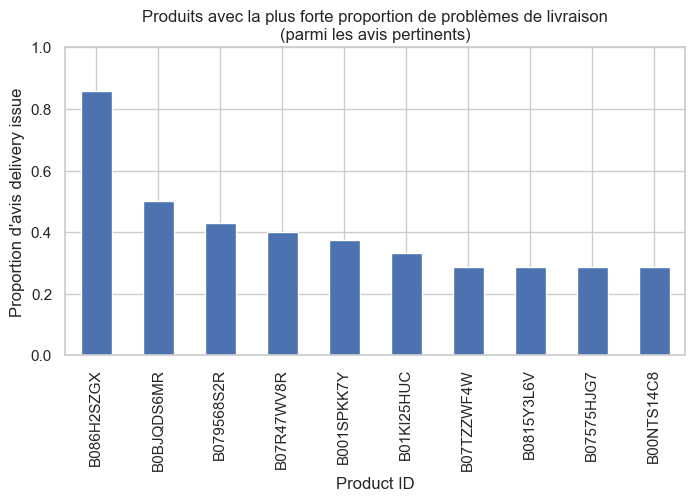

In [ ]:
# Nombre d'avis "delivery issue" pertinents par produit
delivery_relevant_per_product = (
    df_score[df_score["category"] == "delivery issue"]
    .groupby("product_id")
    .size()
    .rename("n_delivery_issues")
)

# Calcul du ratio d'avis "delivery issue" parmi les avis pertinents
delivery_ratio = (
    total_relevant_per_product
    .to_frame()
    .join(delivery_relevant_per_product, how="left")
    .fillna(0)
)

delivery_ratio["delivery_issue_ratio"] = (
    delivery_ratio["n_delivery_issues"] /
    delivery_ratio["n_relevant_reviews"]
)

# Filtrer les produits avec au moins un certain nombre d'avis pertinents
top_delivery_ratio = (
    delivery_ratio[
        delivery_ratio["n_relevant_reviews"] >= min_reviews
    ]
    .sort_values("delivery_issue_ratio", ascending=False)
    .head(10)
)

plt.figure(figsize=(8,4))
top_delivery_ratio["delivery_issue_ratio"].plot(kind="bar")
plt.title("Produits avec la plus forte proportion de problèmes de livraison\n(parmi les avis pertinents)")
plt.ylabel("Proportion d'avis delivery issue")
plt.xlabel("Product ID")
plt.ylim(0, 1)
plt.show()

---

### 😡 Quels produits contiennent la proportion la plus élevée d'avis catégorisés de "mauvaise expérience" ?

Cette analyse mesure la part des avis pertinents décrivant une expérience utilisateur négative.

En raisonnant en proportion plutôt qu’en volume, on identifie les produits pour lesquels la mauvaise expérience constitue un **problème récurrent**, et non un signal isolé.


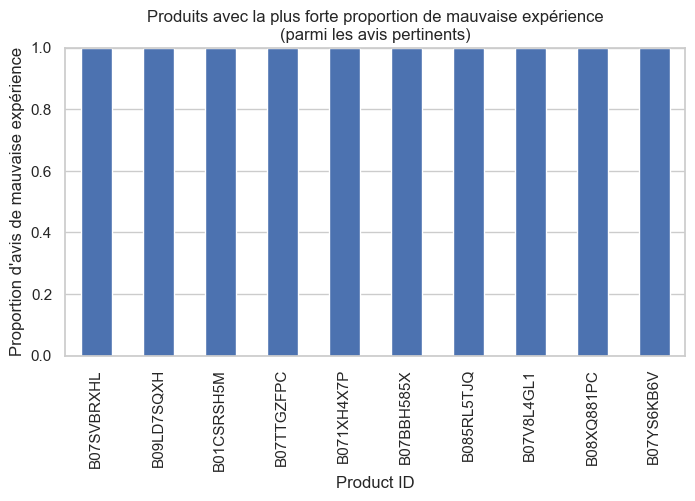

In [57]:
negative_exp_per_product = (
    df_score[df_score["category"] == "negative experience"]
    .groupby("product_id")
    .size()
    .rename("n_negative_experience")
)

negative_exp_ratio = (
    total_relevant_per_product
    .to_frame()
    .join(negative_exp_per_product, how="left")
    .fillna(0)
)

negative_exp_ratio["negative_experience_ratio"] = (
    negative_exp_ratio["n_negative_experience"] /
    negative_exp_ratio["n_relevant_reviews"]
)

top_negative_exp_ratio = (
    negative_exp_ratio[
        negative_exp_ratio["n_relevant_reviews"] >= min_reviews
    ]
    .sort_values("negative_experience_ratio", ascending=False)
    .head(10)
)

plt.figure(figsize=(8,4))
top_negative_exp_ratio["negative_experience_ratio"].plot(kind="bar")
plt.title("Produits avec la plus forte proportion de mauvaise expérience\n(parmi les avis pertinents)")
plt.ylabel("Proportion d'avis de mauvaise expérience")
plt.xlabel("Product ID")
plt.ylim(0, 1)
plt.show()



### 🛠️ Proportion de défauts produit par produit

Cette analyse identifie les produits pour lesquels une part significative des avis pertinents mentionne des défauts matériels ou fonctionnels.

Ce ratio constitue un **indicateur de risque qualité**, utile pour prioriser des audits produit ou des actions correctives.

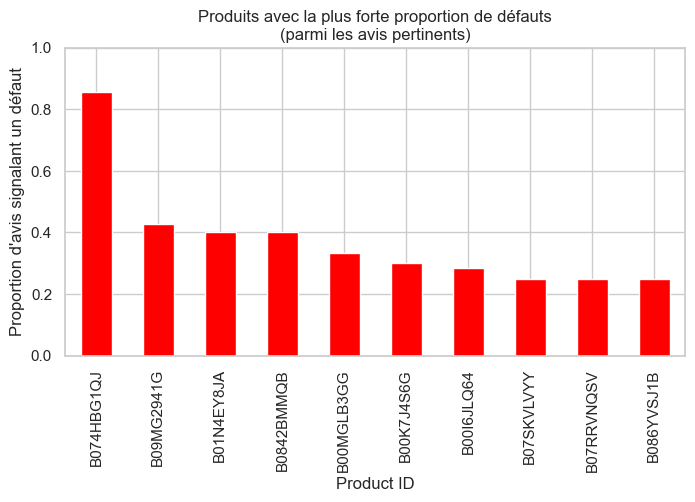

In [58]:
product_defect_per_product = (
    df_score[df_score["category"] == "product defect"]
    .groupby("product_id")
    .size()
    .rename("n_product_defect")
)

product_defect_ratio = (
    total_relevant_per_product
    .to_frame()
    .join(product_defect_per_product, how="left")
    .fillna(0)
)

product_defect_ratio["product_defect_ratio"] = (
    product_defect_ratio["n_product_defect"] /
    product_defect_ratio["n_relevant_reviews"]
)

top_product_defect_ratio = (
    product_defect_ratio[
        product_defect_ratio["n_relevant_reviews"] >= min_reviews
    ]
    .sort_values("product_defect_ratio", ascending=False)
    .head(10)
)

plt.figure(figsize=(8,4))
top_product_defect_ratio["product_defect_ratio"].plot(kind="bar", color="red")
plt.title("Produits avec la plus forte proportion de défauts\n(parmi les avis pertinents)")
plt.ylabel("Proportion d'avis signalant un défaut")
plt.xlabel("Product ID")
plt.ylim(0, 1)
plt.show()


---
---
## 🧾 Conclusion générale

L’objectif de ce notebook était de dépasser une lecture simple des avis clients (volume, note moyenne) afin d’identifier les **avis réellement utiles** et d’en extraire des **signaux métier actionnables**.

---

### 🔍 Synthèse de la démarche

1. Une **catégorisation Zero-Shot** a permis d’assigner à chaque avis un thème sémantique et un score de confiance, sans entraînement supervisé.
2. Un **`relevance_score` composite** a été construit en combinant :
   - la confiance du modèle,
   - la richesse du texte,
   - l’intensité de l’opinion,
   - et des métadonnées (image, achat vérifié, abonnement).
3. Ce score a été **validé quantitativement** (distributions, corrélations) et **qualitativement** (analyse des avis les plus et les moins pertinents).
4. Un **seuil opérationnel (0.45)** a permis d’isoler des avis exploitables, tout en conservant un volume suffisant pour la majorité des produits.
5. Enfin, l’analyse a été traduite en **indicateurs métier par produit**, exprimés en proportion des avis pertinents afin de neutraliser l’effet du volume.

---

### 📊 Principaux enseignements

- Tous les avis ne se valent pas : une large part du contenu est peu informatif, même lorsque la note est élevée.
- Le `relevance_score` permet d’identifier des avis **clairs, tranchés et utiles**, indépendamment de leur polarité.
- Peu de produits disposent d’avis « premium », mais la majorité présente au moins quelques avis exploitables.
- L’analyse en proportion révèle des **problèmes structurels** (livraison, expérience, défauts) qui ne sont pas visibles via les moyennes globales.
- Les avis négatifs pertinents constituent une **source d’information essentielle**, et non un bruit à masquer.

---

### 🧠 Apports métier concrets

Cette approche permet de :
- améliorer l’**affichage des avis** sur une page produit (mettre en avant la qualité plutôt que la récence ou la note),
- détecter des **risques logistiques, UX ou qualité** par produit,
- prioriser des **actions ciblées** pour les équipes produit, supply chain ou support,
- comparer des produits au-delà de leur simple note moyenne.

---

### ⚠️ Limites et perspectives

- Le Zero-Shot reste sensible à l’ambiguïté sémantique et favorise les catégories génériques lorsque le texte est peu explicite.
- Le relevance_score repose sur des pondérations expertes, qui pourraient être affinées ou apprises automatiquement.
- Des extensions naturelles incluent :
  - un **score de risque par produit**,
  - une analyse temporelle des signaux,
  - ou une validation par feedback utilisateur réel.

---

### ✅ Conclusion

Le `relevance_score` constitue un **outil robuste et pragmatique** pour transformer des avis bruts en **insights exploitables**, en conciliant rigueur méthodologique et utilité métier.

Il permet de passer d’une logique de quantité à une logique de **qualité informationnelle**, mieux alignée avec les besoins des utilisateurs finaux comme des équipes internes.
